In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm, trange
import os
from IPython.display import clear_output

import torch
from torch.nn import functional as F
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR


import torchvision
from torchvision import datasets, transforms as tfs

from skimage.io import imread
from PIL import Image

In [2]:
rcParams['figure.figsize'] = (15, 5)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
! unrar x /content/gdrive/MyDrive/PH2Dataset.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/MyDrive/PH2Dataset.rar


Would you like to replace the existing file PH2Dataset/PH2_dataset.txt
 36280 bytes, modified on 2013-07-11 14:07
with a new one
 36280 bytes, modified on 2013-07-11 14:07

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


In [5]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(Image.open(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(Image.open(os.path.join(root, files[0])))

In [6]:
from torchvision.transforms.functional import hflip, rotate

def Augment(X, y):
    if np.random.rand() > 0.65:
        X = hflip(X)
        y = hflip(y)
        ang = np.random.randint(0, 90)
        X = rotate(X, ang)
        y = rotate(y, ang)
    return X, y

In [7]:
transforms = tfs.Compose((
        tfs.Resize((256, 256)),
        tfs.ToTensor())
)

X = np.array([transforms(x) for x in images])
Y = np.array([transforms(y) for y in lesions])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one

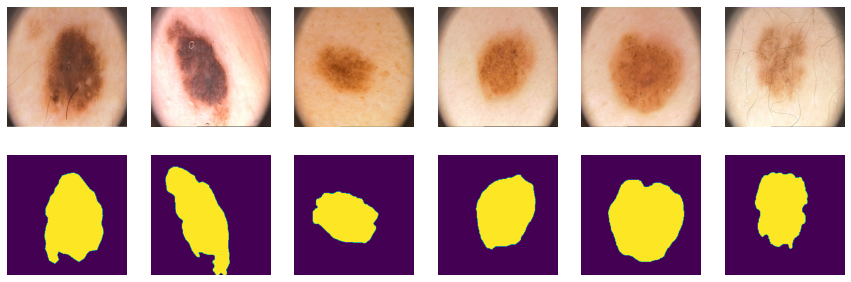

In [8]:
def imshow(X: torch.Tensor, Y: torch.Tensor, n: int, loss=None, acc=None, epoch=None, epochs=None, label=None):
    
    fig, axes = plt.subplots(2, n)

    if label is True:
        plt.title(f'{epoch}/{epochs}  -  loss= {loss}  -  accuracy= {acc}', loc='center')
    
    
    clear_output(wait=True)
    
    axes = axes.flatten()
    for i in range(n):
        axes[i].imshow(np.clip(X[i].detach().cpu().numpy().transpose((1, 2, 0)), 0, 1))
        axes[i].axis('off')

        axes[i + n].imshow(np.squeeze(np.clip(Y[i].detach().cpu().numpy(), 0, 1)))
        axes[i + n].axis('off')

    plt.show()

imshow(X, Y, 6)

In [9]:
from torch.utils.data import random_split

tr, val, ts = random_split(list(range(len(images))), [125, 25, 50])
tr, val, ts = np.array(tr), np.array(val), np.array(ts)
print(len(tr), len(val), len(ts))

125 25 50


In [10]:
BATCH_SIZE = 5
data_tr = torch.utils.data.DataLoader(list(zip(X[tr], Y[tr])), batch_size=BATCH_SIZE)
data_val = torch.utils.data.DataLoader(list(zip(X[val], Y[val])), batch_size=BATCH_SIZE)
data_ts = torch.utils.data.DataLoader(list(zip(X[ts], Y[ts])), batch_size=BATCH_SIZE)

-----------------------------------------------------------------------------------------

# SegNet 

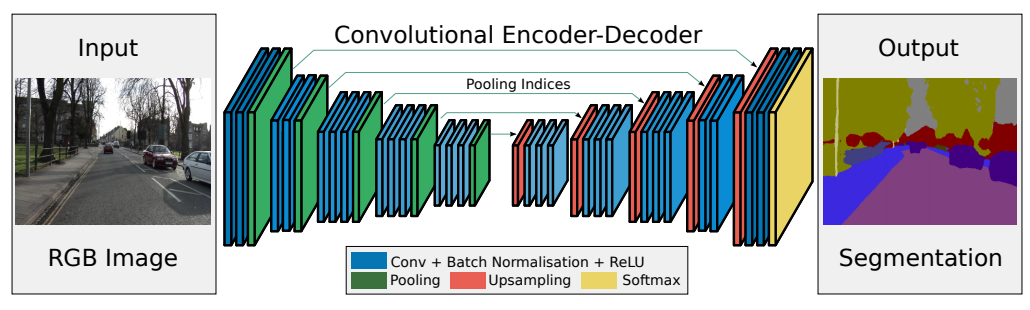



In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.enc1 = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU()
        )
        
        self.enc2 = nn.Sequential(
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
        )
        self.enc3 = nn.Sequential(
                nn.Conv2d(128, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU()
        )
        self.enc4 = nn.Sequential(
                nn.Conv2d(256, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU()
        )
        self.enc5 = nn.Sequential(
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU()
        )
        
        
        
        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        self.dec5 = nn.Sequential(
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU()
        )
        
        self.dec4 = nn.Sequential(
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU()
        )
        
        self.dec3 = nn.Sequential(
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
        )
        
        self.dec2 = nn.Sequential(
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU()
        )
        
        self.dec1 = nn.Sequential(
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 1, 3, padding=1),
                nn.BatchNorm2d(1),
        )
        
    def forward(self, x):
        x, ind1 = self.pool(self.enc1(x))
        x, ind2 = self.pool(self.enc2(x))
        x, ind3 = self.pool(self.enc3(x))
        x, ind4 = self.pool(self.enc4(x))
        x, ind5 = self.pool(self.enc5(x))
        
        x = self.dec5(self.unpool(x, ind5))
        x = self.dec4(self.unpool(x, ind4))
        x = self.dec3(self.unpool(x, ind3))
        x = self.dec2(self.unpool(x, ind2))
        x = self.dec1(self.unpool(x, ind1))
        
        return x

## Metric

We will use the following metric to evaluate the quality:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$



![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)



![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [12]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    
    return thresholded

## Loss

A popular method for binary segmentation is *binary cross-entropy*, which is given as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right],$$

where $y$ is the target of the desired result and $\hat y$ is the output of the model.

However, this loss suffers from numerical instability problems. The most important thing is that $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process. This function is equivalent to the first one and is not so subject to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [13]:
def bce_loss(y_pred, y_true):
    
    loss = (torch.clamp(y_pred, min=0.) - y_true * y_pred + torch.log(1 + torch.exp(-abs(y_pred))))
    return torch.mean(loss)

In [14]:
def score_model(model, data, metric=iou_pytorch):
    model.eval()
    score = 0
    
    with torch.no_grad():
        for X, y in data:
            if torch.cuda.is_available():
                X, y = X.cuda(), y.cuda()
            
            y_pred = torch.round(torch.sigmoid(model(X)))
            
            score += metric(y, y_pred)
            
    return torch.mean(score/len(data)).detach().cpu().numpy().item()

In [15]:
def train(model, opt, loss_fn, scheduler, data_tr=data_tr, data_val=data_val, epochs=50):
    best_acc = 0
    best_params = model.state_dict()
    X_val, y_val = next(iter(data_val))
    if torch.cuda.is_available():
        X_val, y_val = X_val.cuda(), y_val.cuda()
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    for epoch in range(epochs):
        scheduler.step()
        for mode in ['train', 'test']:
            if mode == 'train':
                running_loss = 0
                model.train()
                for X, y in tqdm(data_tr):
                    opt.zero_grad()
                    if torch.cuda.is_available():
                        X, y = Augment(X.cuda(), y.cuda())
                    y_pred = model(X)
                    loss = loss_fn(y, y_pred)
                    loss.backward()
                    opt.step()
                    
                    running_loss += loss.item()
                    
                    del X, y, loss
                    torch.cuda.empty_cache()
                    
                acc = score_model(model, data_tr)

                history['train_loss'].append(running_loss)
                history['train_acc'].append(acc)
                
            else:
                running_loss = 0
                model.eval()
                with torch.no_grad():
                    for X, y in tqdm(data_val):
                        if torch.cuda.is_available():
                            X, y = X.cuda(), y.cuda()
                        y_pred = model(X)
                        running_loss += loss_fn(y_pred, y).item()
                        
                        del X, y
                        
                    acc = score_model(model, data_val)
                     
                    history['test_loss'].append(running_loss)
                    history['test_acc'].append(acc)
                
                if acc > best_acc:
                    best_acc = acc
                    best_params = model.state_dict()
        
        Y_hat = torch.sigmoid(model(X_val))
        
        imshow(X_val, Y_hat, BATCH_SIZE, loss = np.round(running_loss, 5), acc=np.round(acc, 5), epoch=epoch + 1, epochs=epochs, label=True)
        
    model.load_state_dict(best_params)
    
    return model, history

In [16]:
bce_model = SegNet()

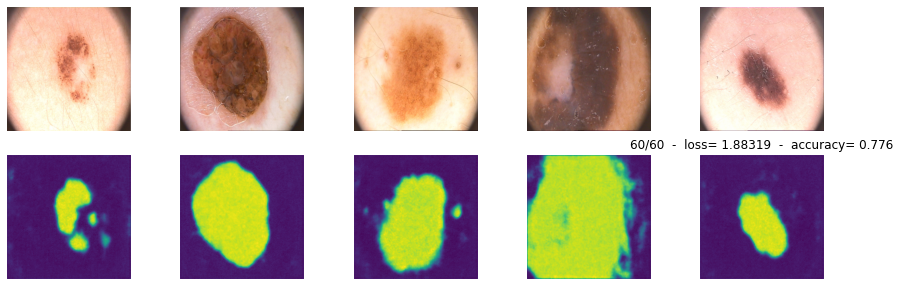

In [17]:
if torch.cuda.is_available():
    bce_model.cuda()

optimizer = torch.optim.Adam(bce_model.parameters(), lr=1e-4) 

loss_fn = bce_loss

lr_scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

bce_model, history1 = train(bce_model, optimizer, loss_fn, lr_scheduler, epochs=60)

In [18]:
score_model(bce_model, data_val, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7760000824928284

In [19]:
score_model(bce_model, data_ts, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7080000638961792

In [65]:
loss1, acc1, val_loss1, val_acc1 = history1['train_loss'], history1['train_acc'], history1['test_loss'], history1['test_acc']

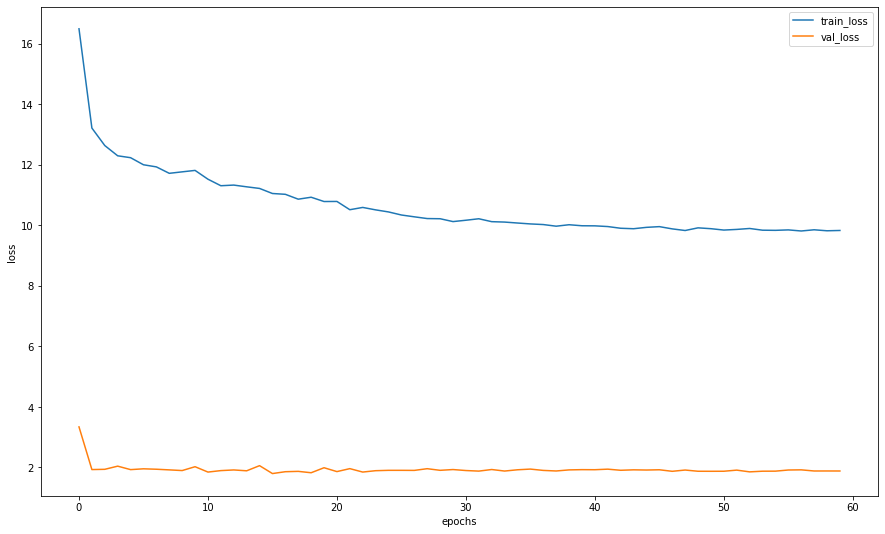

In [63]:
plt.figure(figsize=(15, 9))
plt.plot(loss1, label="train_loss")
plt.plot(val_loss1, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

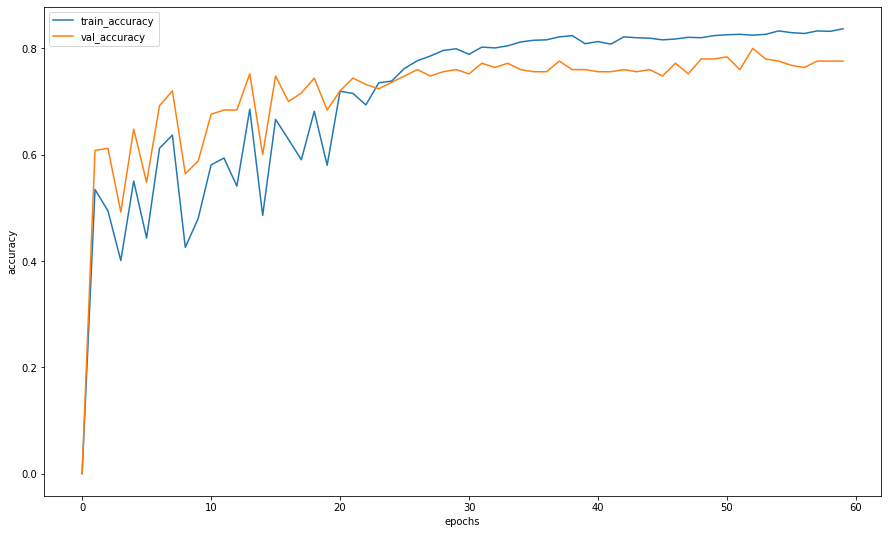

In [64]:
plt.figure(figsize=(15, 9))
plt.plot(acc1, label="train_accuracy")
plt.plot(val_acc1, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь  

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i 2X_iY_i}{\sum_i(X_i+Y_i)}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [23]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = (2*y_real*y_pred).sum()
    den = (y_real + y_pred).sum()
    res = 1 - (num)/(den+1)
    return res 

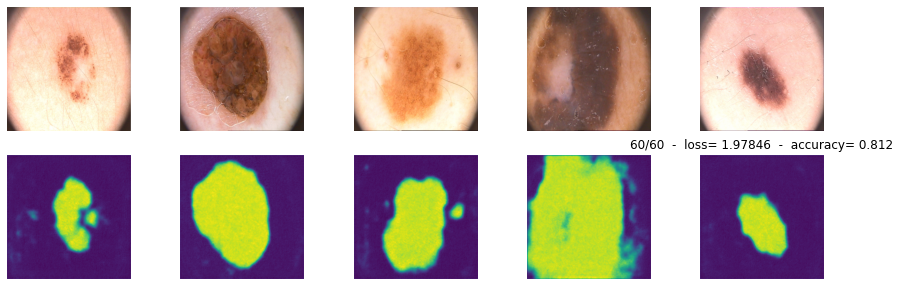

In [24]:
model_dice = SegNet().cuda()

optim = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
lr_sch = StepLR(optim, step_size=20, gamma=0.1)

model_dice, history = train(model_dice, optim, dice_loss, lr_sch, epochs=60)

In [25]:
score_model(model_dice, data_val, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.8119999766349792

In [26]:
score_model(model_dice, data_ts, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7160000205039978

In [27]:
loss2, acc2, val_loss2, val_acc2 = history1['train_loss'], history1['train_acc'], history1['test_loss'], history1['test_acc']

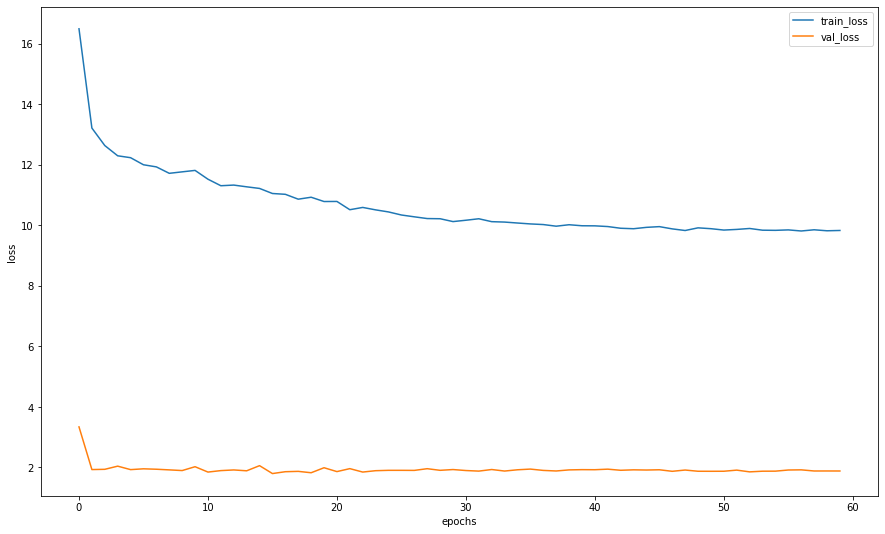

In [28]:
plt.figure(figsize=(15, 9))
plt.plot(loss2, label="train_loss")
plt.plot(val_loss2, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

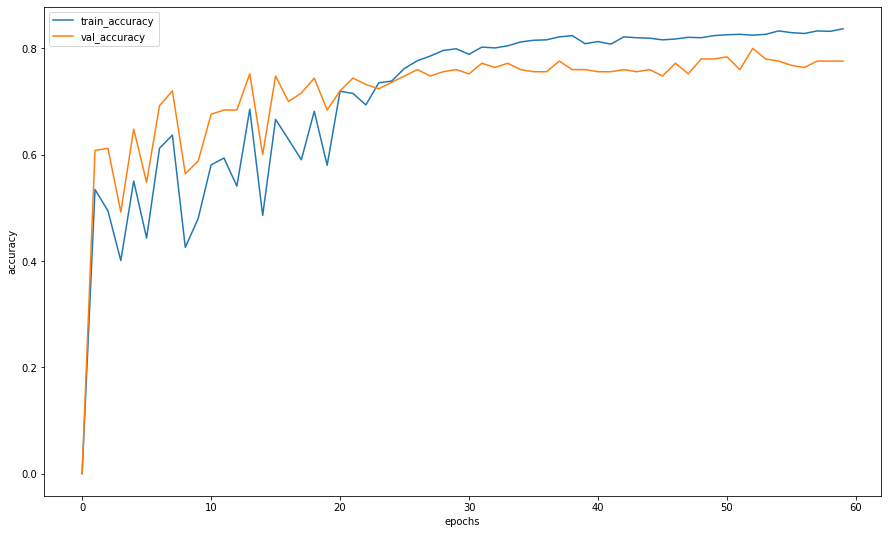

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(acc2, label="train_accuracy")
plt.plot(val_acc2, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### SegNet + focal_loss

**Focal loss:**

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$


In [30]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred, min=eps, max=1-eps)
    y_pred = torch.sigmoid(y_pred)
    y_real = torch.clamp(y_real, min=eps)
    your_loss = -torch.sum(((1-y_pred)**gamma)*y_real*torch.log(y_pred) + (y_pred**gamma)*(1-y_real)*torch.log(1-y_pred))

    return your_loss

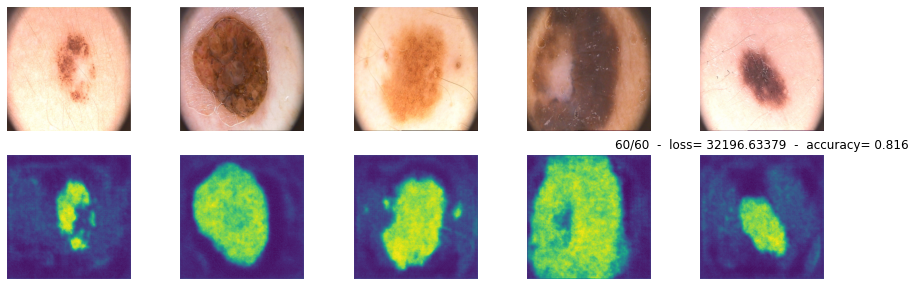

In [31]:
model_focal = SegNet().cuda()

optim = torch.optim.AdamW(model_focal.parameters(), lr=1e-4)
lr_sch = StepLR(optim, step_size=30, gamma=0.1)
model_focal, history = train(model_focal, optim, focal_loss, lr_sch, epochs=60)

In [32]:
score_model(model_focal, data_val, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.8159999847412109

In [33]:
score_model(model_focal, data_ts, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7300000190734863

In [34]:
loss3, acc3, val_loss3, val_acc3 = history1['train_loss'], history1['train_acc'], history1['test_loss'], history1['test_acc']

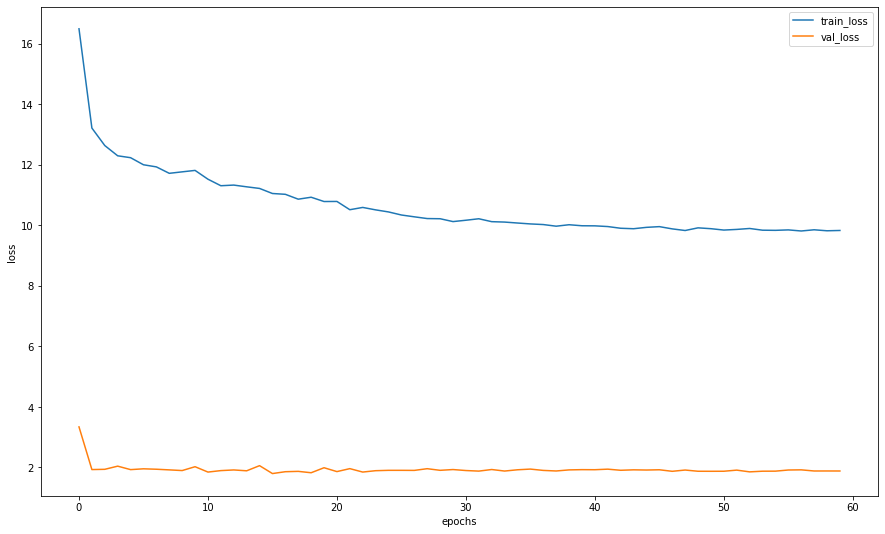

In [35]:
plt.figure(figsize=(15, 9))
plt.plot(loss3, label="train_loss")
plt.plot(val_loss3, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

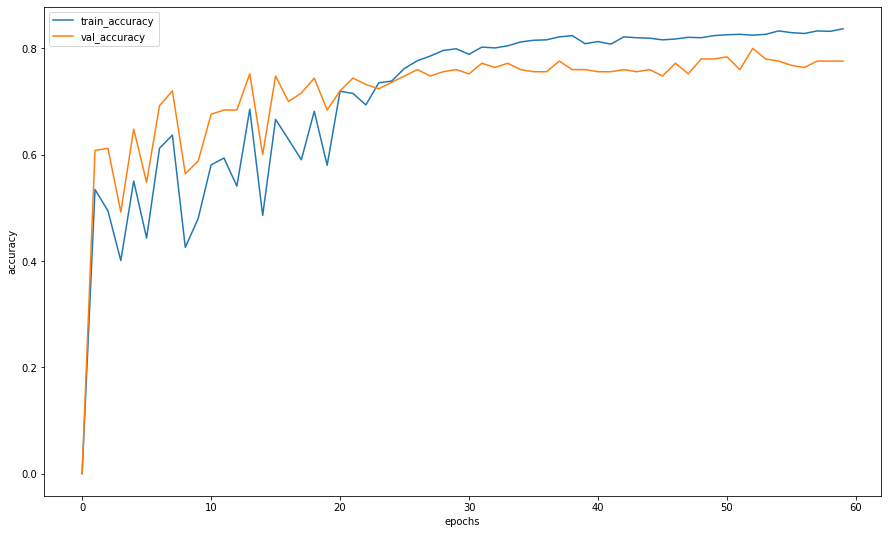

In [36]:
plt.figure(figsize=(15, 9))
plt.plot(acc3, label="train_accuracy")
plt.plot(val_acc3, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### SegNet + SSIM_loss

In [37]:
def SSIM_loss(y_real, y_pred, alpha=0.1, betta=0.2, gamma=0.3):
    y_real = y_real.to('cpu')
    y_pred = y_pred.to('cpu')

    y_pred = torch.sigmoid(y_pred)

    mu_pred = y_pred.sum(2).sum(2).reshape(-1)
    mu_real = y_real.sum(2).sum(2).reshape(-1)

    sig_pred = torch.var(y_pred, dim=(2,3)).reshape(-1)
    sig_real = torch.var(y_real, dim=(2,3)).reshape(-1)
    sig_real_pred = torch.var(y_real*y_pred, dim=(2,3)).reshape(-1)
    sig_pred = torch.sqrt(sig_pred)
    sig_real = torch.sqrt(sig_real)
    sig_real_pred = torch.sqrt(sig_real_pred)

    l = (2*mu_pred*mu_real+1)/(mu_pred**2+mu_real**2+1)
    c = (2*sig_pred*sig_real+1)/(sig_pred**2+sig_real**2+1)
    s = (sig_real_pred+1)/(sig_pred*sig_real+1)

    loss = (l**alpha)*(c**betta)*(s**gamma)
    return torch.mean(1-loss)

In [38]:
model_SSIM = SegNet().cuda()

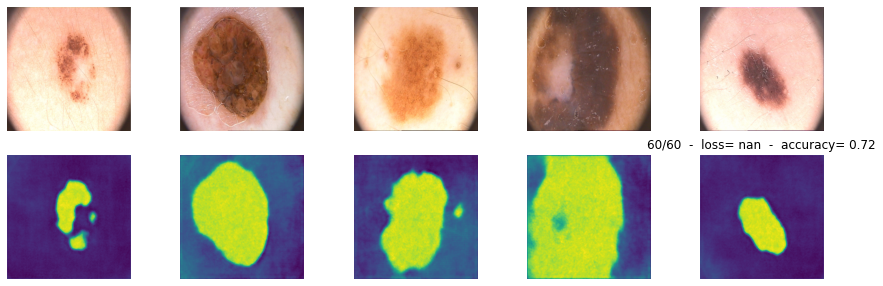

In [39]:
optim = torch.optim.AdamW(model_SSIM.parameters(), lr=1e-4)
lr_sch = StepLR(optim, step_size=30, gamma=0.1)
model_SSIM, history = train(model_SSIM, optim, SSIM_loss, lr_sch, epochs=60)

In [40]:
score_model(model_SSIM, data_val, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7200000286102295

In [41]:
score_model(model_SSIM, data_ts, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6140000224113464

In [56]:
loss4, acc4, val_loss4, val_acc4 = history['train_loss'], history['train_acc'], history['test_loss'], history['test_acc']

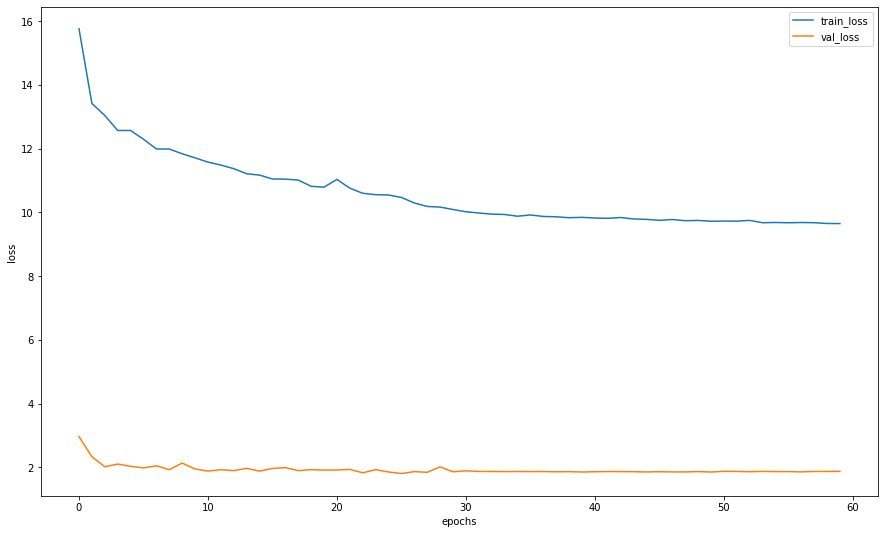

In [57]:
plt.figure(figsize=(15, 9))
plt.plot(loss4, label="train_loss")
plt.plot(val_loss4, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

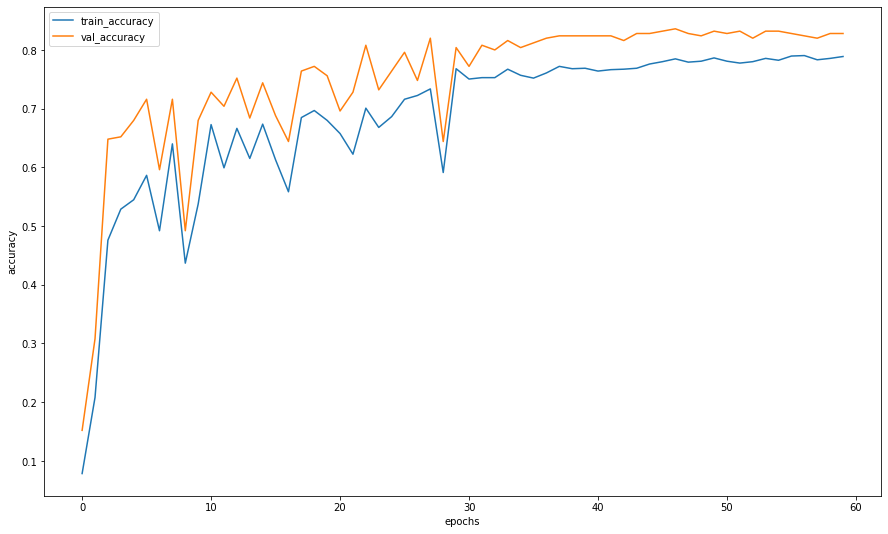

In [58]:
plt.figure(figsize=(15, 9))
plt.plot(acc4, label="train_accuracy")
plt.plot(val_acc4, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [45]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.pool = nn.MaxPool2d(2, 2, return_indices=True)
    
    self.enc1 = nn.Sequential( 
        nn.Conv2d(3, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.enc2 = nn.Sequential( 
        nn.Conv2d(64, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )
    
    self.enc3 = nn.Sequential( 
        nn.Conv2d(128, 256, 3, padding=1), 
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    
    self.enc4 = nn.Sequential(
        nn.Conv2d(256, 512, 3, padding=1), 
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.enc5 = nn.Sequential(
        nn.Conv2d(512, 1024, 3, padding=1), 
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.Conv2d(1024, 1024, 3, padding=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.Conv2d(1024, 512, 3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.unpool = nn.MaxUnpool2d(2, 2)
    
    self.dec4 = nn.Sequential(
        nn.Conv2d(512, 512, 3, padding=1), 
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.dec3 = nn.Sequential(
        nn.Conv2d(256, 256, 3, padding=1), 
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.dec2 = nn.Sequential(
        nn.Conv2d(128, 128, 3, padding=1), 
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.dec1 = nn.Sequential(
        nn.Conv2d(64, 64, 3, padding=1), 
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 1, 3, padding=1),
        nn.BatchNorm2d(1)
    )
    
    

  def forward(self, x):
    p1 = self.enc1(x)
    e1, ind1 = self.pool(p1) # 256 -> 128
    p2 = self.enc2(e1)
    e2, ind2 = self.pool(p2) # 128 -> 64
    p3 = self.enc3(e2)
    e3, ind3 = self.pool(p3) # 64 -> 32
    p4 = self.enc4(e3)
    e4, ind4 = self.pool(p4) # 32 -> 16
    
    n = self.enc5(e4) # 16 -> 16

    d4 = self.dec4(self.unpool(n, ind4) + p4)  # 16 -> 32
    d3 = self.dec3(self.unpool(d4, ind3) + p3)  # 32 -> 64
    d2 = self.dec2(self.unpool(d3, ind2) + p2)  # 64 -> 128
    d1 = self.dec1(self.unpool(d2, ind1) + p1) # 128 -> 256

    return d1


# U-Net


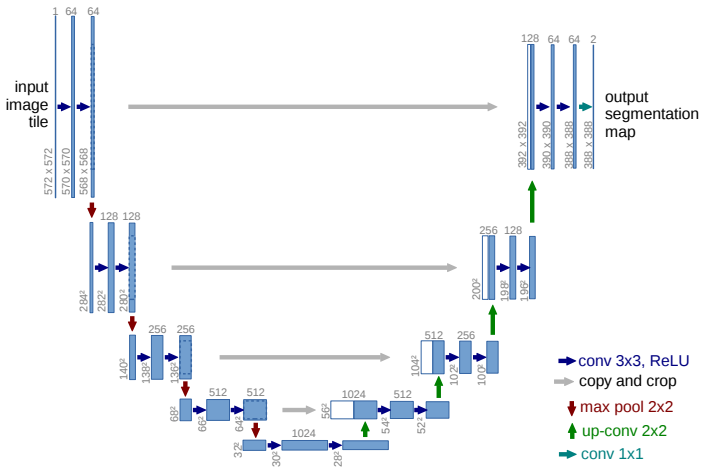

In [46]:
unet_model = UNet().cuda()

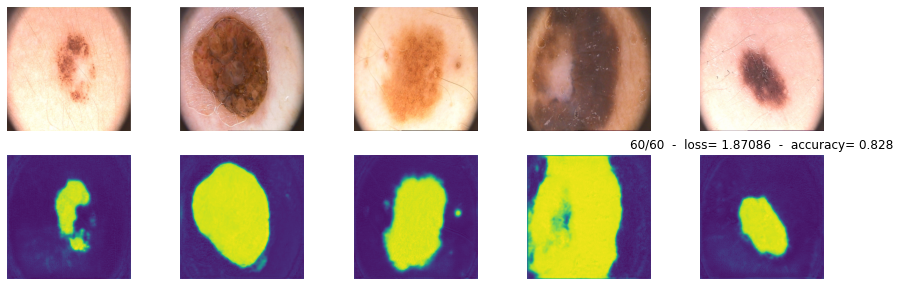

In [47]:
optim = torch.optim.AdamW(unet_model.parameters(), lr=1e-4)
lr_sch = StepLR(optim, step_size=30, gamma=0.1)
unet_model, history = train(unet_model, optim, bce_loss, lr_sch, epochs=60)

In [48]:
score_model(unet_model, data_val, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.8280000686645508

In [49]:
score_model(unet_model, data_ts, iou_pytorch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7160000205039978

In [59]:
loss5, acc5, val_loss5, val_acc5 = history['train_loss'], history['train_acc'], history['test_loss'], history['test_acc']

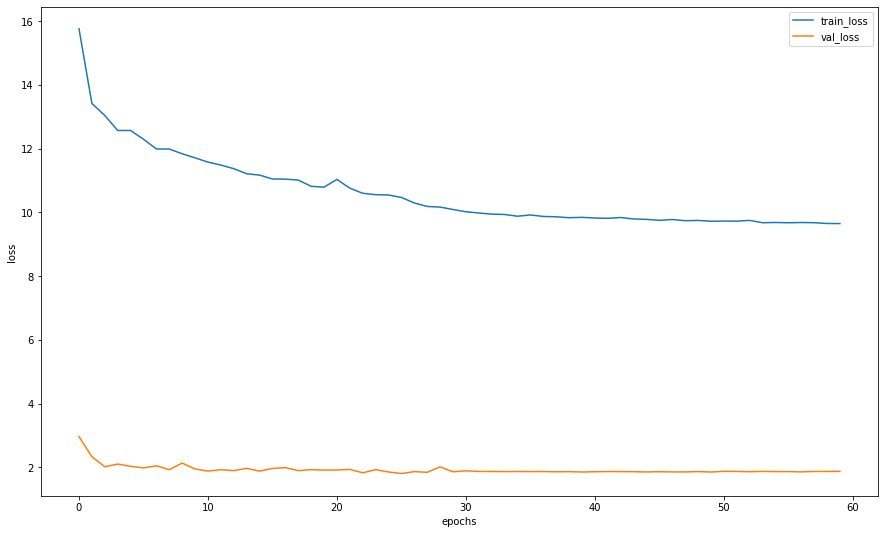

In [60]:
plt.figure(figsize=(15, 9))
plt.plot(loss5, label="train_loss")
plt.plot(val_loss5, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

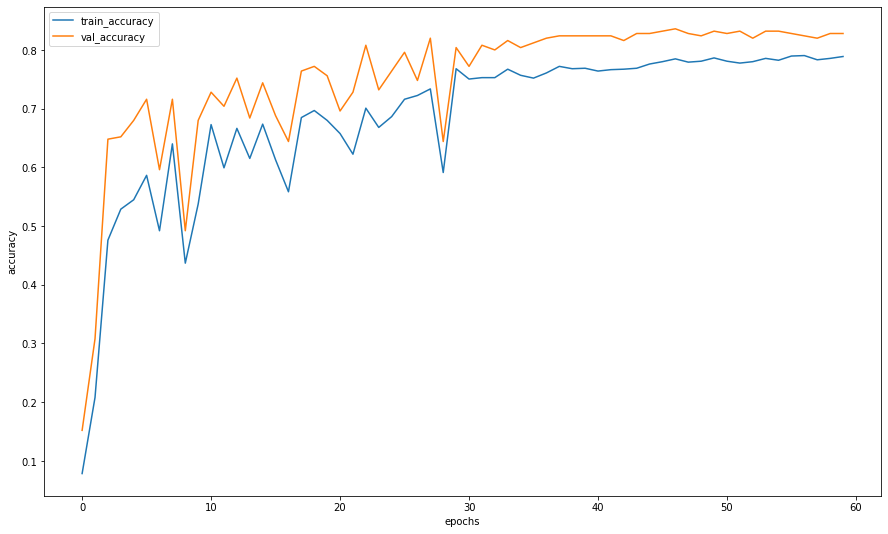

In [61]:
plt.figure(figsize=(15, 9))
plt.plot(acc5, label="train_accuracy")
plt.plot(val_acc5, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

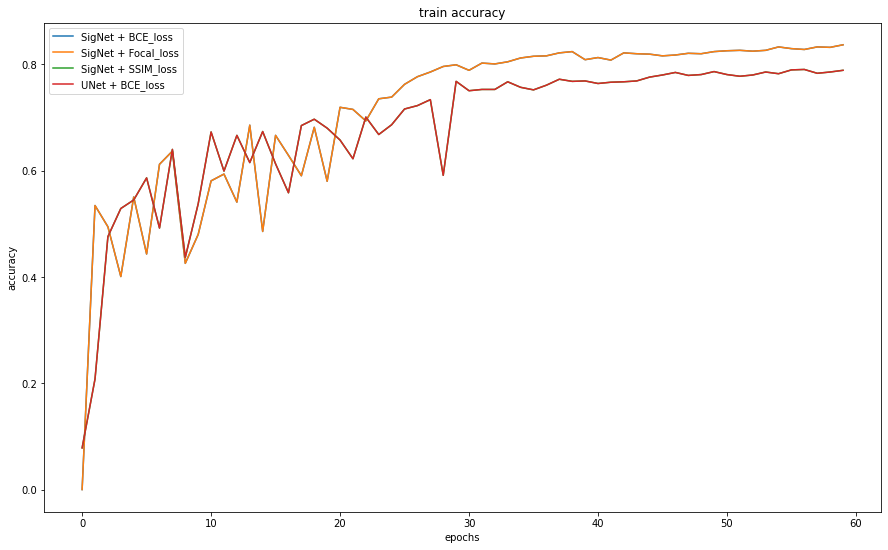

In [66]:
plt.figure(figsize=(15, 9))
plt.plot(acc1, label="SigNet + BCE_loss")
# plt.plot(acc2, label="SigNet + Dice_loss")
plt.plot(acc3, label="SigNet + Focal_loss")
plt.plot(acc4, label="SigNet + SSIM_loss")
plt.plot(acc5, label="UNet + BCE_loss")
plt.legend(loc='best')
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

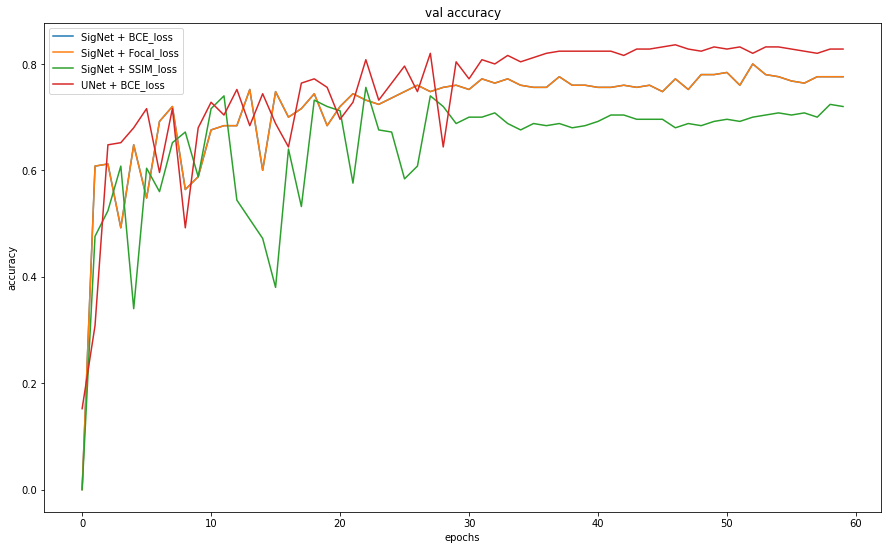

In [55]:
plt.figure(figsize=(15, 9))
plt.plot(val_acc1, label="SigNet + BCE_loss")
# plt.plot(val_acc2, label="SigNet + Dice_loss")
plt.plot(val_acc3, label="SigNet + Focal_loss")
plt.plot(val_acc4, label="SigNet + SSIM_loss")
plt.plot(val_acc5, label="UNet + BCE_loss")
plt.legend(loc='best')
plt.title("val accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()